In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import pandas as pd
import numpy as np
import tensorflow as tf
import settings
from utils import TrainingVisualizationCb
from datetime import datetime

In [3]:
tf.config.list_physical_devices('GPU')

2022-04-19 14:20:57.746725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-04-19 14:20:57.838172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 14:20:57.838947: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Prepare training and validation dataset split

In [4]:
def create_lstm_data(X, y, k):
    '''
    input:
        data - the numpy matrix of (n, p+1) shape, where n is the number of rows,
               p+1 is the number of predictors + 1 target column
        k    - the length of the sequence, namely, the number of previous rows 
               (including current) we want to use to predict the target.
    output:
        X_data - the predictors numpy matrix of (n-k, k, p) shape
        y_data - the target numpy array of (n-k, 1) shape
    '''
    # initialize zero matrix of (n-k, k, p) shape to store the n-k number
    # of sequences of k-length and zero array of (n-k, 1) to store targets
    X_data = np.zeros([X.shape[0]-k, k, X.shape[1]])
    y_data = []
    
    # run loop to slice k-number of previous rows as 1 sequence to predict
    # 1 target and save them to X_data matrix and y_data list
    for i in range(k, X.shape[0]):
        cur_sequence = X[i-k: i, :]
        
        X_data[i-k,:, :] = cur_sequence.reshape(1, k, X_data.shape[2])
        y_data.append(y[i-1])
    
    return X_data, np.asarray(y_data)

In [5]:
df_train = pd.read_csv("./data/train_dataset.csv")
y = df_train.pop("y").values.astype('float32')
X = df_train.values.astype('float32')
del df_train

no_rows = X.shape[0]
data_valid = X[int(no_rows*0.8):,:]
y_valid = y[int(no_rows*0.8):]
data_train = X[:int(no_rows*0.8),:]
y_train = y[:int(no_rows*0.8)]

### Define model

In [6]:
def LSTM_model(X_train, y_train, X_valid, y_valid, k):
    model_name = datetime.now().strftime("%d-%m-%H:%M:%S")
    # Define and compile LSTM model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(k, X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences = False))
    model.add(Dropout(0.2))
    #model.add(LSTM(50))
    #model.add(Dropout(0.2))
    model.add(Dense(1, "tanh"))
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='mse')#,  metrics=[''])
    # Early stopping and best model checkpoint parameters
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=2, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint(f'./models/{model_name}.h5', mode='min', verbose=2, save_best_only=True)
    viz = TrainingVisualizationCb()
    # Train the model 
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=20, verbose=2, callbacks=[mc, viz])

### Train model

2022-04-19 14:21:28.745906: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 14:21:28.747992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 14:21:28.748721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 14:21:28.749343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Epoch 1/20


2022-04-19 14:21:39.559129: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200



Epoch 1: val_loss improved from inf to 0.00103, saving model to ./models/19-04-14:21:28.h5


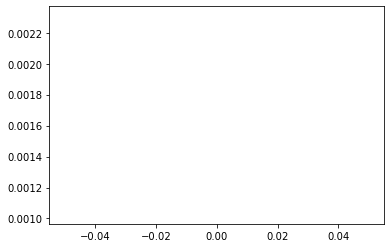

5608/5608 - 68s - loss: 0.0023 - val_loss: 0.0010 - 68s/epoch - 12ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.00103 to 0.00076, saving model to ./models/19-04-14:21:28.h5


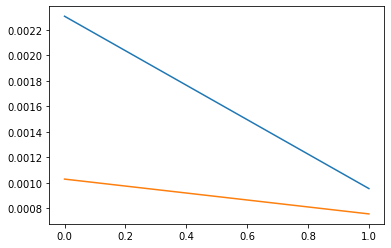

5608/5608 - 58s - loss: 9.5521e-04 - val_loss: 7.5652e-04 - 58s/epoch - 10ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.00076 to 0.00073, saving model to ./models/19-04-14:21:28.h5


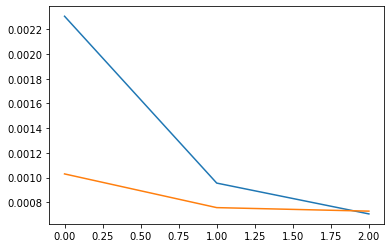

5608/5608 - 59s - loss: 7.0555e-04 - val_loss: 7.2800e-04 - 59s/epoch - 10ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.00073 to 0.00061, saving model to ./models/19-04-14:21:28.h5


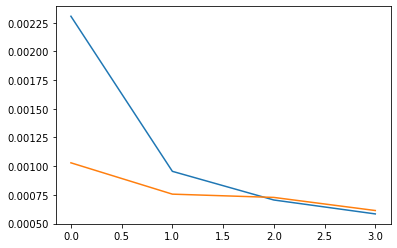

5608/5608 - 58s - loss: 5.8427e-04 - val_loss: 6.1379e-04 - 58s/epoch - 10ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.00061 to 0.00046, saving model to ./models/19-04-14:21:28.h5


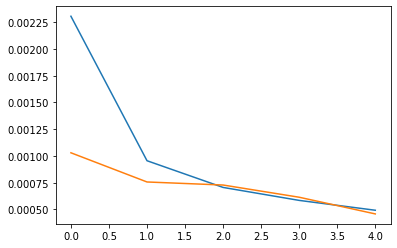

5608/5608 - 58s - loss: 4.9212e-04 - val_loss: 4.5781e-04 - 58s/epoch - 10ms/step
Epoch 6/20

Epoch 6: val_loss improved from 0.00046 to 0.00039, saving model to ./models/19-04-14:21:28.h5


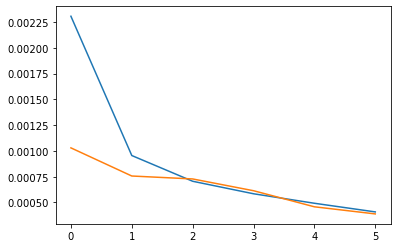

5608/5608 - 58s - loss: 4.0825e-04 - val_loss: 3.8879e-04 - 58s/epoch - 10ms/step
Epoch 7/20

Epoch 7: val_loss improved from 0.00039 to 0.00030, saving model to ./models/19-04-14:21:28.h5


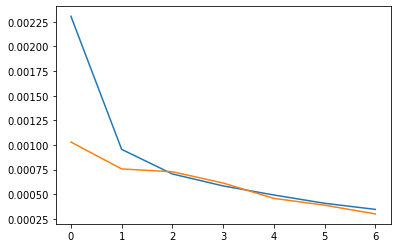

5608/5608 - 58s - loss: 3.4600e-04 - val_loss: 3.0003e-04 - 58s/epoch - 10ms/step
Epoch 8/20

Epoch 8: val_loss improved from 0.00030 to 0.00025, saving model to ./models/19-04-14:21:28.h5


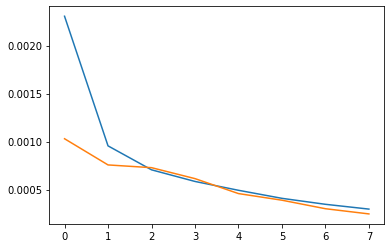

5608/5608 - 58s - loss: 2.9604e-04 - val_loss: 2.4584e-04 - 58s/epoch - 10ms/step
Epoch 9/20

Epoch 9: val_loss improved from 0.00025 to 0.00019, saving model to ./models/19-04-14:21:28.h5


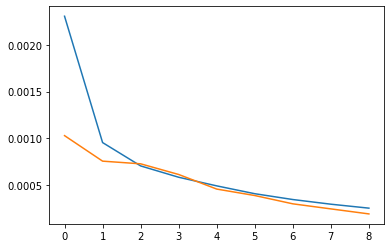

5608/5608 - 59s - loss: 2.5379e-04 - val_loss: 1.9212e-04 - 59s/epoch - 10ms/step
Epoch 10/20

Epoch 10: val_loss improved from 0.00019 to 0.00017, saving model to ./models/19-04-14:21:28.h5


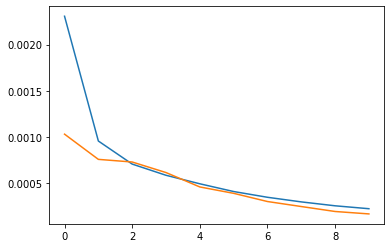

5608/5608 - 58s - loss: 2.2217e-04 - val_loss: 1.6584e-04 - 58s/epoch - 10ms/step
Epoch 11/20

Epoch 11: val_loss improved from 0.00017 to 0.00016, saving model to ./models/19-04-14:21:28.h5


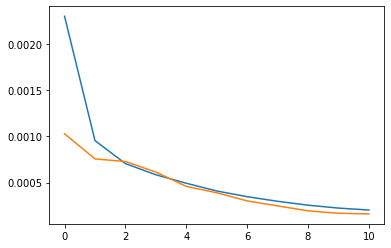

5608/5608 - 58s - loss: 2.0122e-04 - val_loss: 1.5885e-04 - 58s/epoch - 10ms/step
Epoch 12/20

Epoch 12: val_loss improved from 0.00016 to 0.00014, saving model to ./models/19-04-14:21:28.h5


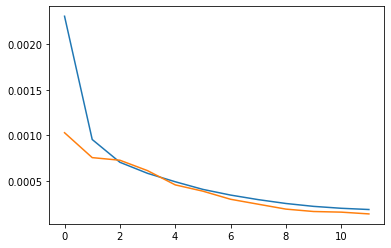

5608/5608 - 58s - loss: 1.8760e-04 - val_loss: 1.3943e-04 - 58s/epoch - 10ms/step
Epoch 13/20

Epoch 13: val_loss did not improve from 0.00014


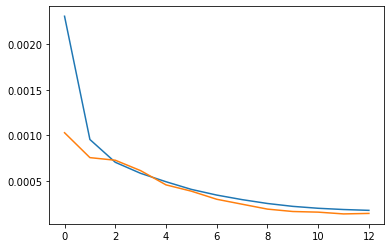

5608/5608 - 59s - loss: 1.7846e-04 - val_loss: 1.4487e-04 - 59s/epoch - 10ms/step
Epoch 14/20

Epoch 14: val_loss improved from 0.00014 to 0.00012, saving model to ./models/19-04-14:21:28.h5


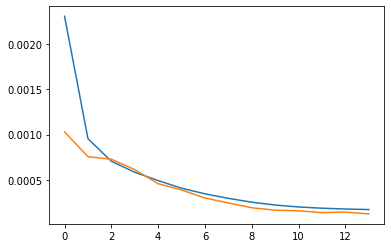

5608/5608 - 58s - loss: 1.7253e-04 - val_loss: 1.2454e-04 - 58s/epoch - 10ms/step
Epoch 15/20

Epoch 15: val_loss did not improve from 0.00012


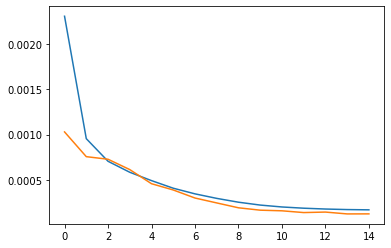

5608/5608 - 58s - loss: 1.6954e-04 - val_loss: 1.2503e-04 - 58s/epoch - 10ms/step
Epoch 16/20

Epoch 16: val_loss did not improve from 0.00012


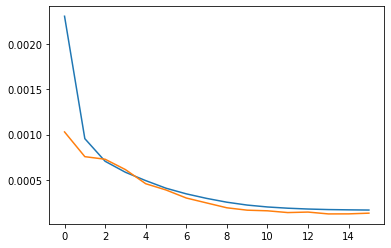

5608/5608 - 58s - loss: 1.6725e-04 - val_loss: 1.3283e-04 - 58s/epoch - 10ms/step
Epoch 17/20

Epoch 17: val_loss improved from 0.00012 to 0.00012, saving model to ./models/19-04-14:21:28.h5


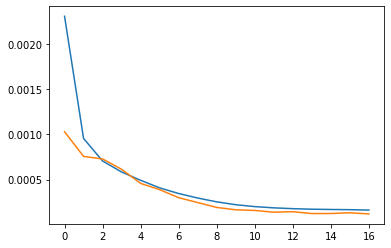

5608/5608 - 58s - loss: 1.6284e-04 - val_loss: 1.2043e-04 - 58s/epoch - 10ms/step
Epoch 18/20

Epoch 18: val_loss did not improve from 0.00012


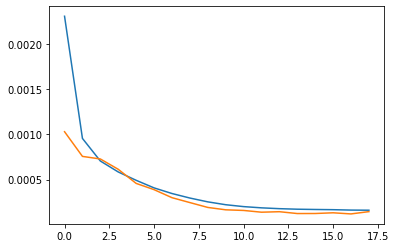

5608/5608 - 59s - loss: 1.6140e-04 - val_loss: 1.4569e-04 - 59s/epoch - 10ms/step
Epoch 19/20

Epoch 19: val_loss did not improve from 0.00012


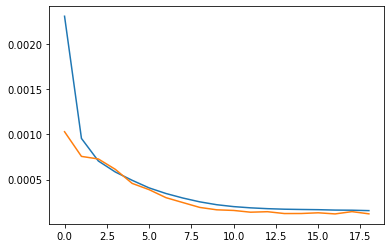

5608/5608 - 58s - loss: 1.5685e-04 - val_loss: 1.2129e-04 - 58s/epoch - 10ms/step
Epoch 20/20

Epoch 20: val_loss improved from 0.00012 to 0.00012, saving model to ./models/19-04-14:21:28.h5


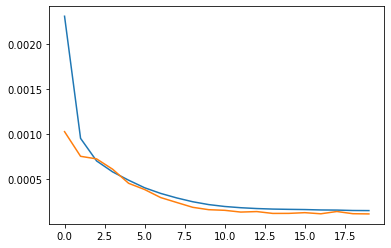

5608/5608 - 58s - loss: 1.5580e-04 - val_loss: 1.1904e-04 - 58s/epoch - 10ms/step


In [7]:
X_train, y_train = create_lstm_data(data_train, y_train, settings.SEQUENCE_LENGTH)
X_valid, y_valid = create_lstm_data(data_valid, y_valid, settings.SEQUENCE_LENGTH)

LSTM_model(X_train, y_train, X_valid, y_valid, settings.SEQUENCE_LENGTH)

### Validate

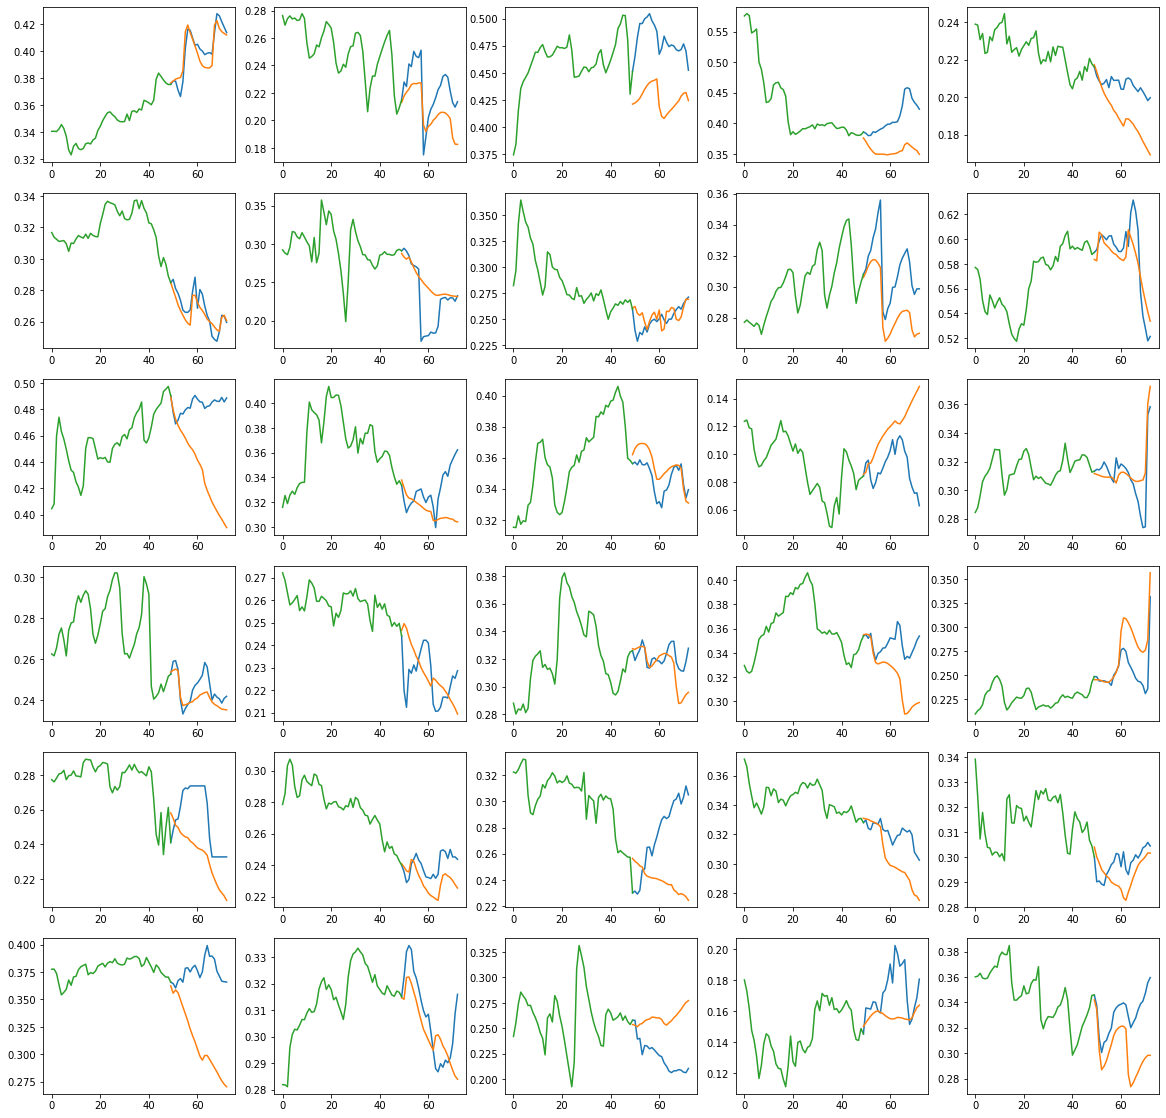

In [10]:
from utils import plot_random

model = keras.models.load_model('./models/19-04-14:21:28.h5')
plot_random(X, y, 30, model)